In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations, df

In [4]:
images, annotations, df = load_data("../../../../images/", '../../../../emo-at-cap.csv')

In [5]:
import pickle
with open('emotion_features.pl', 'rb') as f:
    emotion_features = pickle.load(f)

In [6]:
sentiment = df['sentiment'].values

# Processing of data

In [7]:
import nltk

In [8]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [9]:
from sklearn.preprocessing import OneHotEncoder

In [10]:
one_hot_enc = OneHotEncoder()
sentiment = one_hot_enc.fit_transform(sentiment.reshape(-1,1))

In [11]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [12]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [13]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [14]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [15]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [16]:
len(unique_tokens)

2162

In [17]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [18]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [19]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [20]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [21]:
padded_sentences = padd(tokenized, pad_token, start_token, end_token, maxlen=10)

In [22]:
np.mean([len(i) for i in padded_sentences])

12.0

In [23]:
indexed = list(map(lambda x: [vocab[i] for i in x],padded_sentences))

In [24]:
images.shape

(3840, 224, 224, 3)

In [25]:
len(class_weights)

2162

In [26]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [27]:
len(class_weights), len(vocab)

(2165, 2165)

In [28]:
class_weights[:4]

[1, 1, 1, 0.21013259327782918]

In [29]:
class_weights = np.array(class_weights)

In [30]:
class_weights.shape

(2165,)

# Model with transfer learning

In [31]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [32]:
import tensorflow.keras.applications as apps


In [33]:
tf.keras.models.load_model('encoder.h5').summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2951

In [34]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, trainable=False):
        super(ConvEncoder, self).__init__()
        #loading pretrained encoder
        self.encoder = tf.keras.models.load_model('encoder.h5')
        self.encoder.trainable=trainable
        
        #on top layers
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')
        
    def call(self, input):
        features = self.encoder(input)
        return [self.dense1(features), self.dense2(features)]

In [35]:
conv_encoder = ConvEncoder()

In [36]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [37]:
conv_res

[<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
 array([[0.        , 0.        , 0.        , 1.0086081 , 0.        ,
         0.        , 0.        , 0.3388536 , 0.90186745, 0.        ,
         0.08384687, 0.        , 0.8661702 , 0.5179372 , 0.9656877 ,
         0.        , 1.1475537 , 2.1070385 , 0.        , 1.2647513 ,
         0.17619482, 0.        , 1.7335383 , 0.        , 0.        ,
         0.        , 2.378471  , 0.7384177 , 0.        , 0.3117122 ,
         0.        , 0.05571342, 2.558331  , 0.01345447, 1.4646363 ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.35214263, 0.24265972, 0.        ,
         1.0334202 , 0.9934166 , 0.5819897 , 1.0697776 , 0.9315593 ,
         0.33432746, 0.        , 0.        , 0.        , 0.41010714,
         1.5011369 , 0.1665098 , 0.5563164 , 0.        , 0.05463475,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.4977178 , 1.3831835 , 0.        , 0.     

### LSTM model

### making w2v embeddings

In [38]:
!pip install gensim

     |████████████████████████████████| 23.9 MB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 7.7 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [39]:
import gensim.downloader as api

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [40]:
w2v_embeddings = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [41]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [42]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### building model

In [78]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        self.dense_emo = tf.keras.layers.Dense(units=lstm_units, activation='relu')
        self.dense_sen = tf.keras.layers.Dense(units=lstm_units, activation='relu')

        
    def call(self, input, features, emo_feature, sen_feature):
        embedded = self.dropout(self.embeddings(input))
        emo_feature = self.dense_emo(emo_feature)
        sen_feature = self.dense_sen(sen_feature)
        concated = tf.concat([embedded,\
                              tf.expand_dims(emo_feature, 1),tf.expand_dims(sen_feature, 1),], axis=-1)
        result_lstm, state_h, state_c = self.lstm(concated, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [79]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

### Training

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [47]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [49]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [80]:
@tf.function
def train_step(image, target, emo_feature, sen_feature, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state,emo_feature=emo_feature, sen_feature=sen_feature)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [81]:
@tf.function
def evaluate(image, target, emo_feature, sen_feature, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state,emo_feature=emo_feature, sen_feature=sen_feature)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [57]:
sentiment = sentiment.toarray()

In [58]:
train_images, val_images, train_sequences, val_sequences, train_emo, val_emo, train_sen, val_sen =  train_test_split(images, indexed, emotion_features, sentiment, test_size=0.2, random_state=10)
val_images, test_images, val_sequences, test_sequences, val_emo, test_emo, val_sen, test_sen =  train_test_split(val_images, val_sequences,val_emo, val_sen, test_size=0.5, random_state=10)

In [59]:
train_length = (np.array(train_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [60]:
val_length = (np.array(val_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [61]:
test_length = (np.array(test_sequences)!=vocab[pad_token]).sum(axis=1)-2

In [62]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size)).astype('float32')
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size)).astype('float32')
val_images = np.array(np.array_split(val_images, len(val_images)//batch_size)).astype('float32')

train_emo = np.array(np.array_split(train_emo, len(train_emo)//batch_size)).astype('float32')
test_emo = np.array(np.array_split(test_emo, len(test_emo)//batch_size)).astype('float32')
val_emo = np.array(np.array_split(val_emo, len(val_emo)//batch_size)).astype('float32')

train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
val_sequences = np.array(np.array_split(val_sequences, len(val_sequences)//batch_size))

train_length = np.array(np.array_split(train_length, len(train_length)//batch_size)).astype('float32')
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size)).astype('float32')
val_length = np.array(np.array_split(val_length, len(val_length)//batch_size)).astype('float32')

train_sen = np.array(np.array_split(train_sen, len(train_sen)//batch_size)).astype('float32')
test_sen = np.array(np.array_split(test_sen, len(test_sen)//batch_size)).astype('float32')
val_sen = np.array(np.array_split(val_sen, len(val_sen)//batch_size)).astype('float32')

In [63]:
train_images.shape, train_sequences.shape, train_length.shape

((48, 64, 224, 224, 3), (48, 64, 12), (48, 64))

In [64]:
!pip install tqdm

     |████████████████████████████████| 76 kB 5.2 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [65]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [66]:
from tqdm import tqdm

In [82]:
train_loss = []
train_perplexity = []
val_loss = []
val_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_val_loss = 0
    epoch_val_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length, batched_train_emo, batched_train_sen in tqdm(zip(train_images,train_sequences,train_length, train_emo, train_sen)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_emo,batched_train_sen, batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_val_images, batch_val_sequences, batched_val_length, batched_test_emo, batched_val_sen in zip(val_images,val_sequences,val_length, val_emo, val_sen):
        batched_val_loss, batched_val_perplexity = evaluate(batch_val_images, batch_val_sequences, batched_test_emo,batched_val_sen, batched_val_length, optimizer)
        epoch_val_loss+=batched_val_loss
        epoch_val_perplexity+=batched_val_perplexity
    epoch_val_loss = epoch_val_loss/val_images.shape[0]
    epoch_val_perplexity = epoch_val_perplexity/val_images.shape[0]
    val_perplexity.append(epoch_val_perplexity)
    val_loss.append(epoch_val_loss)
    print('Validation loss : {}; Validation perplexity : {}'.format(epoch_val_loss,epoch_val_perplexity))
    if len(val_loss)>=2 and val_loss[-2]<val_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in validation loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

48it [00:27,  1.73it/s]


Finished epoch 0; Train loss : 7.298180103302002; Train perplexity : 1990.16845703125
Validation loss : 6.348039627075195; Validation perplexity : 578.04248046875


48it [00:07,  6.52it/s]


Finished epoch 1; Train loss : 5.785907745361328; Train perplexity : 336.2943115234375
Validation loss : 5.4780402183532715; Validation perplexity : 242.06410217285156


48it [00:07,  6.51it/s]


Finished epoch 2; Train loss : 5.15247106552124; Train perplexity : 175.5017547607422
Validation loss : 5.032931804656982; Validation perplexity : 155.21571350097656


48it [00:07,  6.54it/s]


Finished epoch 3; Train loss : 4.721048831939697; Train perplexity : 113.951904296875
Validation loss : 4.678837776184082; Validation perplexity : 109.22437286376953


48it [00:07,  6.52it/s]


Finished epoch 4; Train loss : 4.370309352874756; Train perplexity : 80.2542495727539
Validation loss : 4.401780605316162; Validation perplexity : 83.03508758544922


48it [00:07,  6.53it/s]


Finished epoch 5; Train loss : 4.0949320793151855; Train perplexity : 60.952266693115234
Validation loss : 4.188127517700195; Validation perplexity : 67.21302795410156


48it [00:07,  6.48it/s]


Finished epoch 6; Train loss : 3.8740978240966797; Train perplexity : 48.88322067260742
Validation loss : 4.019766330718994; Validation perplexity : 56.903446197509766


48it [00:07,  6.48it/s]


Finished epoch 7; Train loss : 3.6946351528167725; Train perplexity : 40.85348892211914
Validation loss : 3.8875572681427; Validation perplexity : 49.93423080444336


48it [00:07,  6.48it/s]


Finished epoch 8; Train loss : 3.5491631031036377; Train perplexity : 35.31862258911133
Validation loss : 3.784613847732544; Validation perplexity : 45.10893249511719


48it [00:07,  6.48it/s]


Finished epoch 9; Train loss : 3.4302618503570557; Train perplexity : 31.352798461914062
Validation loss : 3.703653573989868; Validation perplexity : 41.6470832824707


48it [00:07,  6.43it/s]


Finished epoch 10; Train loss : 3.330942392349243; Train perplexity : 28.38088035583496
Validation loss : 3.638845682144165; Validation perplexity : 39.0700569152832


48it [00:07,  6.46it/s]


Finished epoch 11; Train loss : 3.245964765548706; Train perplexity : 26.060792922973633
Validation loss : 3.586045980453491; Validation perplexity : 37.09010696411133


48it [00:07,  6.49it/s]


Finished epoch 12; Train loss : 3.1717379093170166; Train perplexity : 24.188623428344727
Validation loss : 3.5423424243927; Validation perplexity : 35.528072357177734


48it [00:07,  6.47it/s]


Finished epoch 13; Train loss : 3.105748414993286; Train perplexity : 22.63653564453125
Validation loss : 3.505819082260132; Validation perplexity : 34.27395248413086


48it [00:07,  6.47it/s]


Finished epoch 14; Train loss : 3.046217203140259; Train perplexity : 21.32122802734375
Validation loss : 3.4748945236206055; Validation perplexity : 33.24794387817383


48it [00:07,  6.49it/s]


Finished epoch 15; Train loss : 2.991877794265747; Train perplexity : 20.186996459960938
Validation loss : 3.448481321334839; Validation perplexity : 32.396949768066406


48it [00:07,  6.36it/s]


Finished epoch 16; Train loss : 2.94173264503479; Train perplexity : 19.19362449645996
Validation loss : 3.4257748126983643; Validation perplexity : 31.683744430541992


48it [00:07,  6.48it/s]


Finished epoch 17; Train loss : 2.8950374126434326; Train perplexity : 18.31229591369629
Validation loss : 3.406153917312622; Validation perplexity : 31.081335067749023


48it [00:07,  6.52it/s]


Finished epoch 18; Train loss : 2.8512232303619385; Train perplexity : 17.52193260192871
Validation loss : 3.388958215713501; Validation perplexity : 30.564008712768555


48it [00:07,  6.51it/s]


Finished epoch 19; Train loss : 2.809830904006958; Train perplexity : 16.806467056274414
Validation loss : 3.3738632202148438; Validation perplexity : 30.118070602416992


48it [00:07,  6.50it/s]


Finished epoch 20; Train loss : 2.7705039978027344; Train perplexity : 16.153661727905273
Validation loss : 3.3605613708496094; Validation perplexity : 29.731630325317383


48it [00:07,  6.46it/s]


Finished epoch 21; Train loss : 2.732957124710083; Train perplexity : 15.55395221710205
Validation loss : 3.348947286605835; Validation perplexity : 29.399991989135742


48it [00:07,  6.48it/s]


Finished epoch 22; Train loss : 2.6969292163848877; Train perplexity : 14.999346733093262
Validation loss : 3.3388442993164062; Validation perplexity : 29.116060256958008


48it [00:07,  6.46it/s]


Finished epoch 23; Train loss : 2.6622612476348877; Train perplexity : 14.48428726196289
Validation loss : 3.330183982849121; Validation perplexity : 28.87715721130371


48it [00:07,  6.47it/s]


Finished epoch 24; Train loss : 2.6287553310394287; Train perplexity : 14.003268241882324
Validation loss : 3.3227498531341553; Validation perplexity : 28.67584991455078


48it [00:07,  6.45it/s]


Finished epoch 25; Train loss : 2.5962812900543213; Train perplexity : 13.552239418029785
Validation loss : 3.3165123462677; Validation perplexity : 28.510095596313477


48it [00:07,  6.49it/s]


Finished epoch 26; Train loss : 2.564757823944092; Train perplexity : 13.128277778625488
Validation loss : 3.311300277709961; Validation perplexity : 28.375030517578125


48it [00:07,  6.49it/s]


Finished epoch 27; Train loss : 2.534034490585327; Train perplexity : 12.727843284606934
Validation loss : 3.307307481765747; Validation perplexity : 28.275863647460938


48it [00:07,  6.45it/s]


Finished epoch 28; Train loss : 2.5040571689605713; Train perplexity : 12.348876953125
Validation loss : 3.304332733154297; Validation perplexity : 28.20624542236328


48it [00:07,  6.48it/s]


Finished epoch 29; Train loss : 2.474766492843628; Train perplexity : 11.989453315734863
Validation loss : 3.302508592605591; Validation perplexity : 28.170785903930664


# Viewing and saving results

In [83]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning_w2v_autoenc_fixed_size_emotions_sentiment'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['val_perplexity'] = [i.numpy() for i in val_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['val_loss'] = [i.numpy() for i in val_loss]


In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

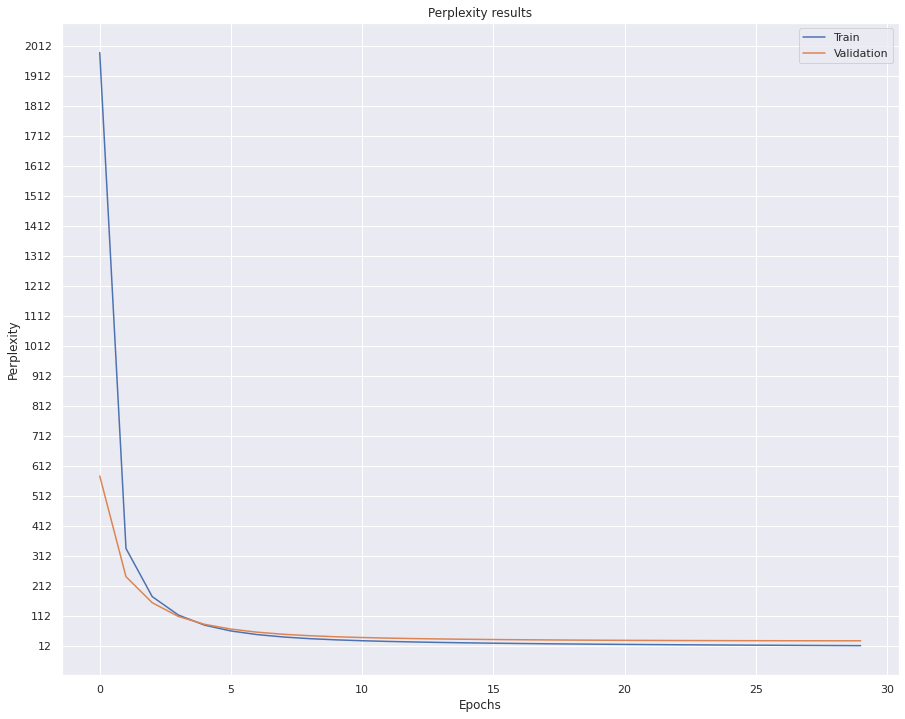

In [85]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['val_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Validation']);

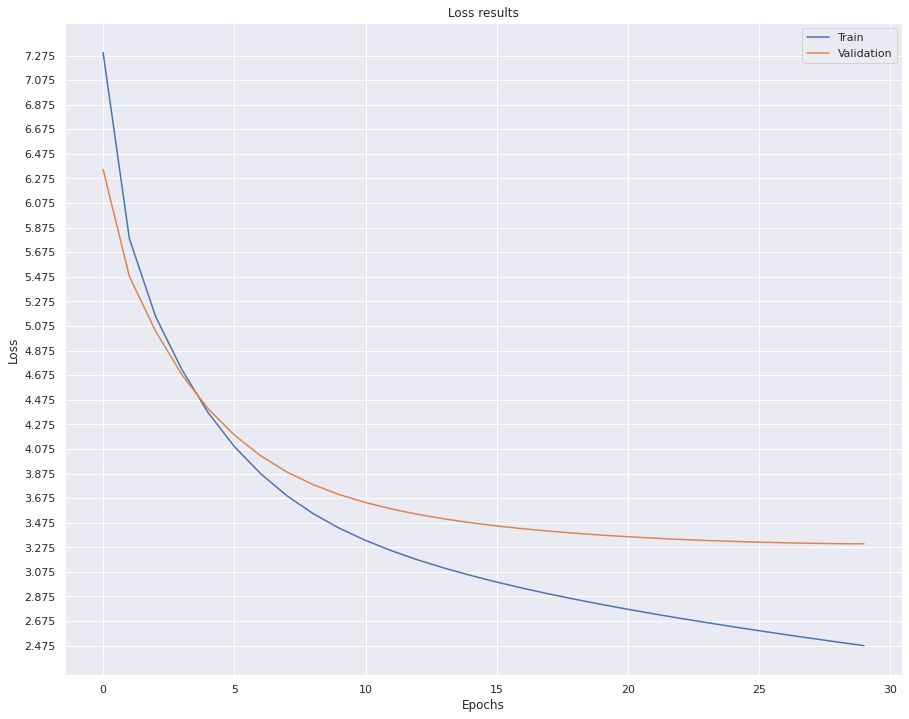

In [86]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['train_loss']),0.2))
plt.legend(['Train', 'Validation']);

# Testing model

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, emo_feature, sen_feature):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        emo_feature = tf.expand_dims(emo_feature, axis=0)
        sen_feature = tf.expand_dims(sen_feature, axis=0)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state,  emo_feature, sen_feature)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [109]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, emo_feature, sen_feature, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))
        emo_feature = tf.expand_dims(emo_feature, axis=0)
        sen_feature = tf.expand_dims(sen_feature, axis=0)

        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state = self.decoder(target_seq, initial_state, emo_feature, sen_feature)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [110]:
def predict(data, emo_feature, sen_feature, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data,emo_feature, sen_feature,  beam_size=beam_size)
    else:
        result = decoder.decode(data,emo_feature, sen_feature, )
    return ' '.join([inverse_vocab[i] for i in result])

In [111]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=20)

In [112]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=20)

In [113]:
images.shape

(3840, 224, 224, 3)

In [149]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

the woman is laughing at something


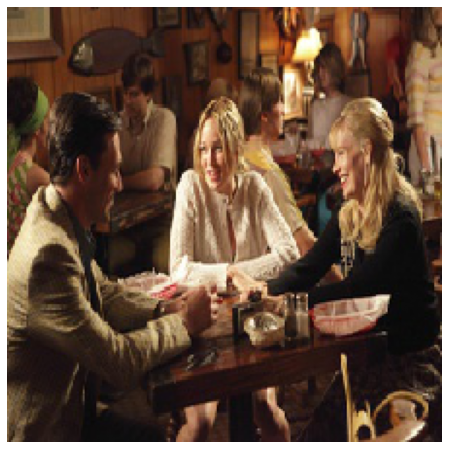

In [150]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [151]:
predict(sample, emotion_features[idx], sentiment[idx], greedy_decoder, inverse_vocab)

'the woman is happy to see her boyfriend'

In [152]:
predict(sample, emotion_features[idx], sentiment[idx], beam_decoder, inverse_vocab, beam_size=3)

'the man is flirting with the woman'

In [153]:
predict(sample,emotion_features[idx], sentiment[idx],  beam_decoder, inverse_vocab, beam_size=5)

'the man is flirting with the woman'

In [154]:
predict(sample, emotion_features[idx], sentiment[idx], beam_decoder, inverse_vocab, beam_size=7)

'the man is flirting with the woman'

In [155]:
predict(sample,emotion_features[idx], sentiment[idx],  beam_decoder, inverse_vocab, beam_size=10)

'the man is flirting with the woman'

# Blue score calculation

In [156]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [157]:
test_predictions = []
for batch_image, batch_emo, batch_sentiment in tqdm(zip(test_images, test_emo, test_sen)):
    for image, emo, sen in zip(batch_image, batch_emo, batch_sentiment):
        result = predict(image, emo,sen, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

6it [08:02, 80.38s/it]


In [158]:
test_predictions = [i.split(' ') for i in test_predictions]

In [159]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [160]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [161]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.05864208634112777


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [162]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.2673562526619276


In [163]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.12839758856541628


In [164]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.07376925635157551


In [165]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.04952898427393867


In [166]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.05864208634112777


In [167]:
df.head()

,train_perplexity,val_perplexity,train_loss,val_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,1990.168457,578.042480,7.298180,6.348040,5.864209,26.735625,12.839759,7.376926,4.952898,5.864209
1,336.294312,242.064102,5.785908,5.478040,5.864209,26.735625,12.839759,7.376926,4.952898,5.864209
2,175.501755,155.215714,5.152471,5.032932,5.864209,26.735625,12.839759,7.376926,4.952898,5.864209
3,113.951904,109.224373,4.721049,4.678838,5.864209,26.735625,12.839759,7.376926,4.952898,5.864209
4,80.254250,83.035088,4.370309,4.401781,5.864209,26.735625,12.839759,7.376926,4.952898,5.864209


In [168]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [151]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [152]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))